In [1]:
import pandas as pd
import numpy as np
from itertools import product
# might be add in requirements.txt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
# Statsmodel
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# Scikit-learn
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error


%matplotlib inline
sns.set()

In [2]:
# Import the data
df = pd.read_csv("./train.csv", parse_dates=["datetime"])
df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# Let's get the most important statistics
df.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


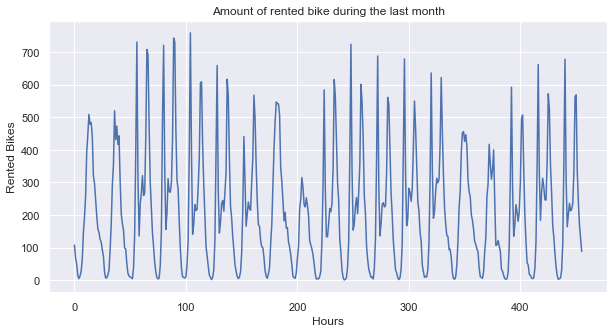

In [4]:
# Let's graph the series during the last month. The train data only includes the first 19 days of the month
plt.figure(figsize=(10, 5))
plt.plot(df["count"].values[-456:])
plt.title("Amount of rented bike during the last month")
plt.ylabel("Rented Bikes")
plt.xlabel('Hours')
plt.show()


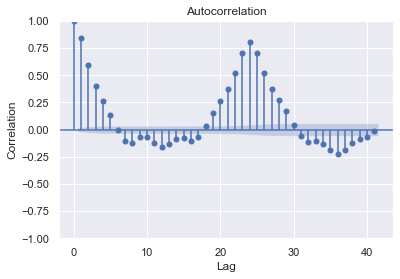

In [5]:
# Using some built-in functions, let's determine if the data is seasonal or not. 
# If the autocorrelation plot shows a sinusoidal shape, the data is seasonal (i.e., periodic)
# We prefer seasonal data because it is easier to make predictions on it (using historical data). 
# Lags are previous timesteps

plot_acf(df['count'].values)
plt.xlabel("Lag")
plt.ylabel("Correlation")
plt.show()

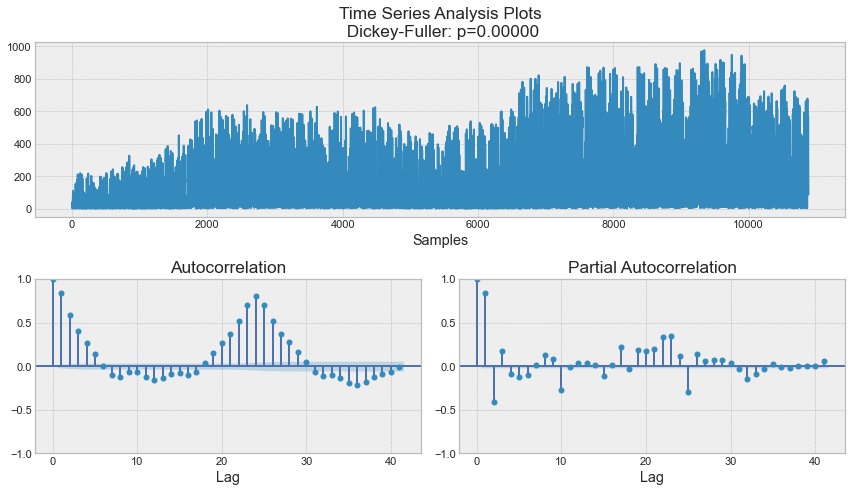

In [6]:
# Another way to have more information is using both the autocorrelation and the partial autocorrelation. 
# Additionally we can perform an hypothesis test to check if our data is stationary or not. 
# The lags are the number of previous time steps

def tsplot(y, lags=None, figsize=(12, 7), syle='bmh'):
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style='bmh'):
        # Create figure and axes
        fig = plt.figure(figsize=figsize)
        layout = (2,2)
        ts_ax = plt.subplot2grid(layout, (0,0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1,0))
        pacf_ax = plt.subplot2grid(layout, (1,1))
        
        # Pot the variable
        y.plot(ax=ts_ax)
        # Returns the p_value of the Dickey-Fuller test. If p_value = 1, the process is not stationary
        # If the process is stationary (p_value = 0), then the series has a constant mean.
        p_value = adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        ts_ax.set_xlabel("Samples")
        plot_acf(y, lags=lags, ax=acf_ax)
        acf_ax.set_xlabel("Lag")
        plot_pacf(y, lags=lags, ax=pacf_ax, method="ywm")
        pacf_ax.set_xlabel("Lag")
        plt.tight_layout()
        
tsplot(df["count"].values)

# Notice that the ACF shows a sine-wave shape pattern, the PACF has spikes at lags 1 and 2, 
# and no correlation for other lags, which means a probable AR order of 2 and seasonal AR order of 2
# For the PACF plot, initial spikes at lag = 1 and 2 and seasonal spikes at lag = 24, 
# which means a probable MA order of 2 and seasonal MA order of 2

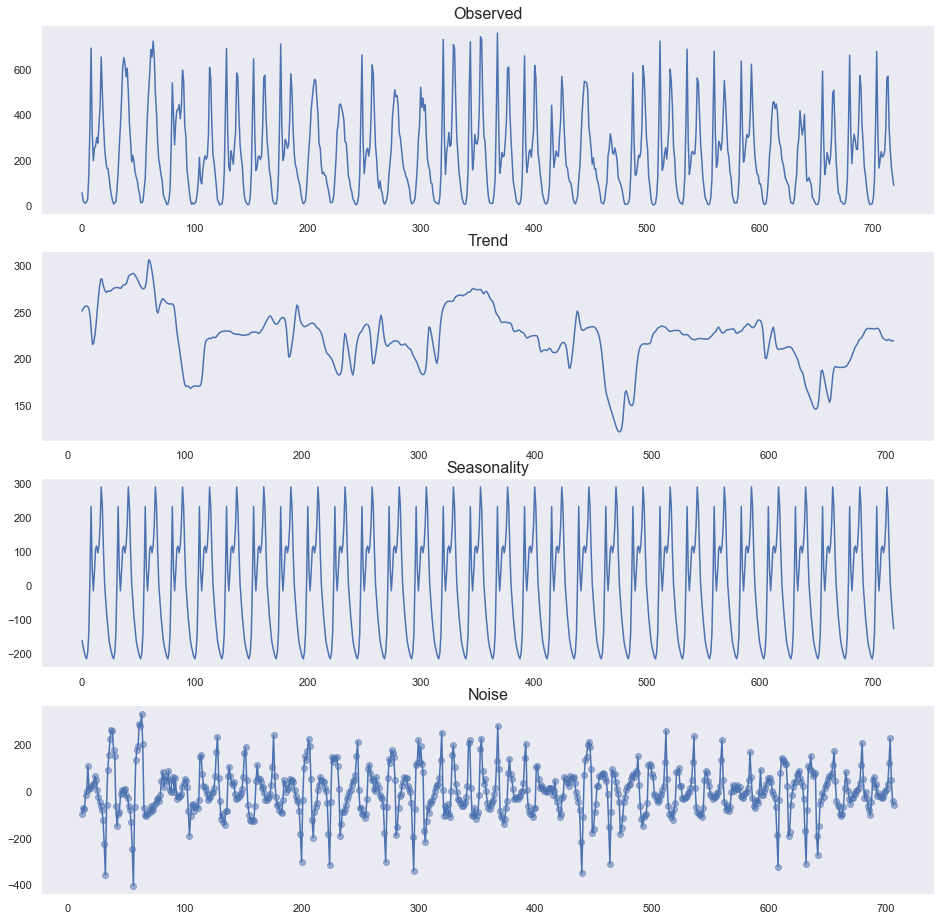

In [7]:
# There's another graphical built-in function to see if a process is seasonal or not.
def decompose_bike_sharing_demand(df, share_type='count', samples=250, period=24):
    if samples == 'all':
        res = seasonal_decompose(df[share_type].values, period=period)
    else:
        res = seasonal_decompose(df[share_type].values[-samples:], period=period)
    
    observed = res.observed
    trend = res.trend
    seasonal = res.seasonal
    residual = res.resid

    fig, axs = plt.subplots(4, figsize=(16,16))
    axs[0].set_title('Observed', fontsize=16)
    axs[0].plot(observed)
    axs[0].grid()
    
    axs[1].set_title('Trend', fontsize=16)
    axs[1].plot(trend)
    axs[1].grid()

    axs[2].set_title('Seasonality', fontsize=16)
    axs[2].plot(seasonal)
    axs[2].grid()

    axs[3].set_title('Noise', fontsize=16)
    axs[3].plot(residual)
    axs[3].scatter(y=residual, x=range(len(residual)), alpha=0.5)
    axs[3].grid()
    
    plt.show()

# We will examine the last reported month in periods of 24 hours.
decompose_bike_sharing_demand(df, samples=720, period=24)

## Moving Average

In [8]:
# Then we need to find a model that allow us to capture the singularities of this process 
# (e.g., mean, variance, seasonality, stationarity) so we are able to predict the future. 

# One of the easiest ways to model time series data is through the Moving Average, 
# which predicts the next value or observation is the mean of past values or observations (called window). 

# The longer the window, the smoother the variations (tendency to the mean), the smaller the window, 
# the most likely the model will follow the trend. 

def plot_moving_average(series, window, plot_intervals=False, scale=1.96):

    rolling_mean = series.rolling(window=window).mean()
    
    plt.figure(figsize=(17,8))
    plt.plot(series[window:], label='Actual values')
    plt.title('Moving average\n window size = {}'.format(window))
    plt.plot(rolling_mean, 'g', label='Rolling mean trend')
    
    #Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bound = rolling_mean - (mae + scale * deviation)
        upper_bound = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bound, 'r--', label='Upper bound / Lower bound')
        plt.plot(lower_bound, 'r--')
            
    
    plt.legend(loc='best')
    plt.grid(True)


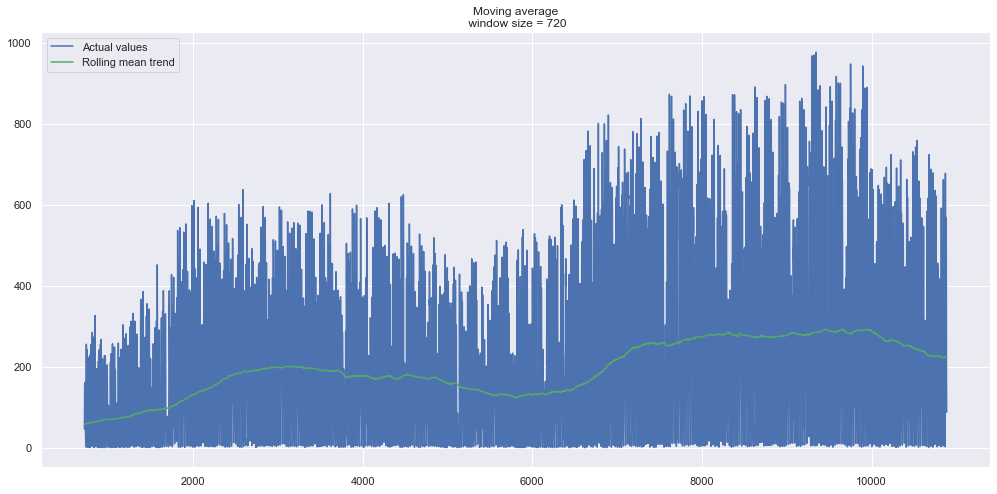

In [12]:
# Smooth by the previous 1 days (24 hours)
plot_moving_average(pd.Series(df["count"].values), window=720, plot_intervals=False)

## SARIMA (Seasonal Autoregressive Integrated Moving Average)

In [13]:
"""
SARIMA is the combination of the autoregressive part with the moving average. 
This is specially useful to time series that exhibit seasonality.

As its name indicates, the first part is an autoregression (AR). 
Basically, we assume that an observation depends on its previous observations within some lag. 
Therefore, it exists strong correlation between the observations in a period of time. 

In the moving average (MA) part, we assume that there is strong correlation within the window. 

"""

from statsmodels.tsa.statespace.sarimax import SARIMAX


# include I if the data is non stationary
sarima_model = SARIMAX(
    pd.Series(df["count"].values),
    order=(2, 0, 2), # p=order[0], d=order[1], q=order[2], AR(p), I(d), MA(q)
    seasonal_order=(2, 0, 2, 24), # Seasonality: P=seasonal_order[0], D=seasonal_order[1], Q=seasonal_order[2], s=seasonal_order[3]
)
trained_model = sarima_model.fit(disp=-1)
print(trained_model.summary()) 

# Use the trained model to predict 
predictions = trained_model.predict()
# Fix the predictions, we know that we cannot have -1 rented bike
predictions[predictions < 0] =0
print(f"MAPE: {mean_absolute_percentage_error(pd.Series(df['count'].values), predictions)}%")

# Some Results
# SARIMAX(1, 0, 1)x(1, 0, 1, 24) --> MAPE: 0.5182085671253294%
# SARIMAX(0, 1, 0) --> MAPE: 0.5896235403262953%
# SARIMAX(0, 1, 0)x(0, 1, 0, 6)  --> MAPE: 0.8328176193518243%
# SARIMAX(0, 1, 0)x(1, 0, 0, 12) --> MAPE: 0.6259597313147078%
# SARIMAX(2, 0, 0)x(1, 0, 0, 24) --> MAPE: 0.4436969647510891%
# SARIMAX(1, 0, 2)x(1, 0, [1], 24) --> MAPE: 0.5213048599649486%

/Users/paola/opt/anaconda3/envs/iot/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                10886
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood              -60219.745
Date:                            Tue, 29 Mar 2022   AIC                         120457.489
Time:                                    18:40:36   BIC                         120523.146
Sample:                                         0   HQIC                        120479.620
                                          - 10886                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4090      0.011    -38.844      0.000      -0.430      -0.388
ar.L2          0.5460      0.007   

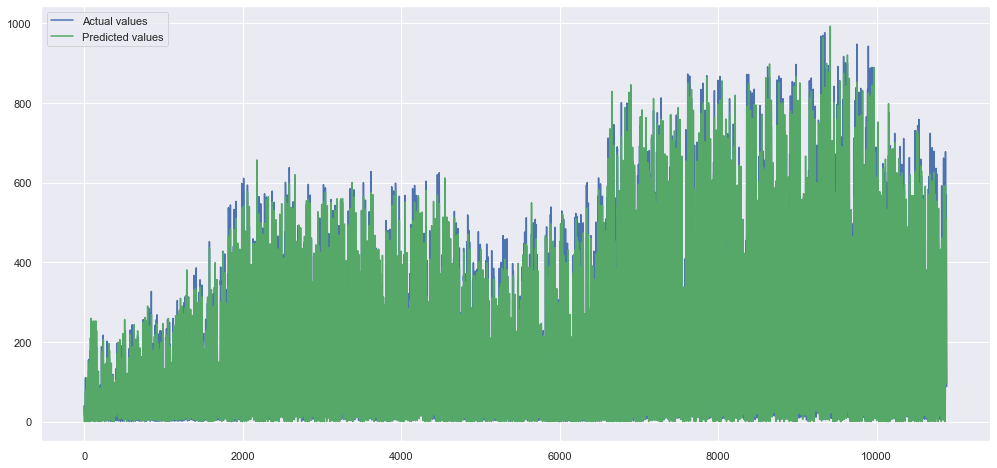

In [14]:
# Plot the predictions
plt.figure(figsize=(17,8))
plt.plot(pd.Series(df["count"].values), label='Actual values')
plt.plot(predictions, 'g', label='Predicted values')
plt.legend(loc='best')
plt.grid(True)

## Grid Search of hyperparameters

In [ ]:
#Set initial values and some bounds
ps = range(0, 3)
d = 0  # our data is stationary
qs = range(0, 3)
Ps = range(0, 3)
D = 0  # our data is stationary
Qs = range(0, 3)
s = 24

#Create a list with all possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
print(len(parameters_list))


def optimize_SARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
    """
    
    results = []
    best_aic = float('inf')
    
    for param in tqdm(parameters_list):
        try: model = SARIMAX(pd.Series(df["count"].values), order=(param[0], d, param[1]),
                                               seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        
        #Save best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
        
    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    #Sort in ascending order, lower AIC is better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
# Get the results of the hyperparameter optimization
result_table = optimize_SARIMA(parameters_list, d, D, s)

/Users/paola/opt/anaconda3/envs/iot/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  456
Model:             SARIMAX(2, 0, 2)x(2, 0, 2, 24)   Log Likelihood               -2554.048
Date:                            Tue, 29 Mar 2022   AIC                           5126.096
Time:                                    18:43:57   BIC                           5163.199
Sample:                                         0   HQIC                          5140.712
                                            - 456                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5148      0.045     33.855      0.000       1.427       1.603
ar.L2         -0.5344      0.034   

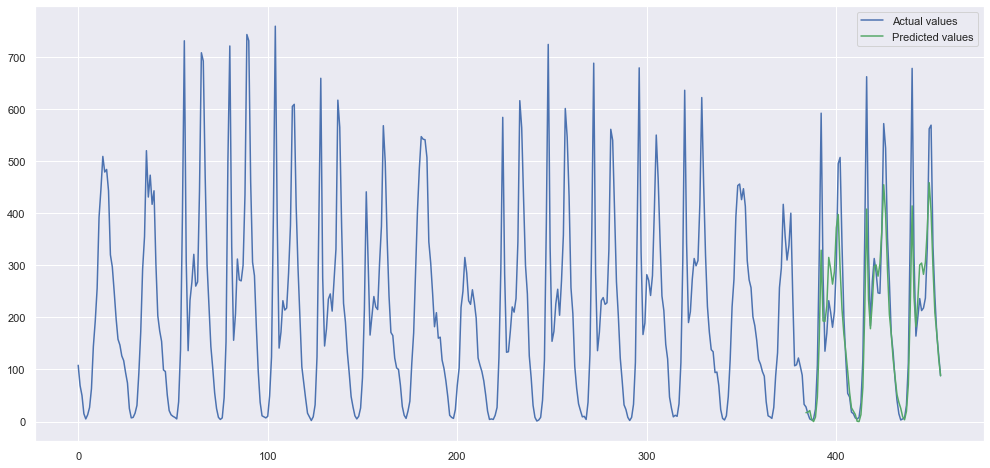

In [15]:
# At the end the ultimate goal is to predict the last ten days of the total number of rented bikes having the first 20 days. 
# We will do it for the last month but the same can be done for the other months. 

# 19*24=456 --> We have an hourly report
sarima_model = SARIMAX(
    pd.Series(df["count"].values[-456:]),
    order=(2, 0, 2), # p=order[0], d=order[1], q=order[2], AR(p), I(d), MA(q)
    seasonal_order=(2, 0, 2, 24), # Seasonality: P=seasonal_order[0], D=seasonal_order[1], Q=seasonal_order[2], s=seasonal_order[3]
)
# Don't display any warning during training. 
trained_model = sarima_model.fit(disp=-1)
print(trained_model.summary()) 

# We can test the model using the training data, for example, trying to predict the last three days 
predictions = trained_model.predict(start=384, end=455, dynamic=True)
# Fix the predictions, we know that we cannot have -1 rented bike
predictions[predictions < 0] =0
# print(f"MAPE: {mean_absolute_percentage_error(pd.Series(df['count'].values[-456:]), predictions)}%")


# Plot the predictions
plt.figure(figsize=(17,8))
plt.plot(pd.Series(df["count"].values[-456:]), label='Actual values')
plt.plot(predictions, 'g', label='Predicted values')
plt.legend(loc='best')
plt.grid(True)

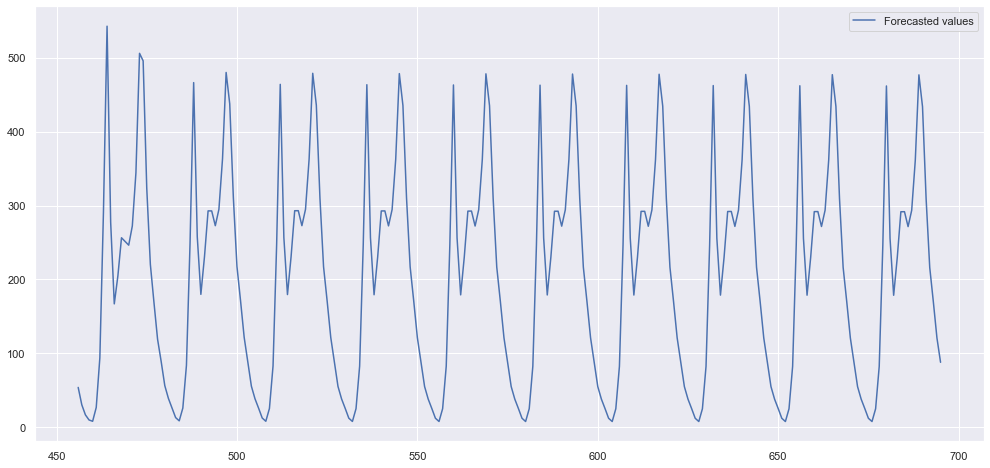

In [16]:
# We can use the model to predict the following ten days 
future_predictions = trained_model.predict(start=456, end=695, dynamic=True)
future_predictions.describe()
plt.figure(figsize=(17,8))
plt.plot(future_predictions, label='Forecasted values')
plt.legend(loc='best')
plt.grid(True)

In [17]:
from pandas.tseries.offsets import DateOffset

# Generate future dates
last_month_df = df.iloc[-456:, :]
last_month_df["datetime"] = pd.to_datetime(last_month_df["datetime"])
last_month_df.set_index("datetime",inplace=True)
last_month_df.index[-1]
future_dates=[last_month_df.index[-1]+ DateOffset(hours=x)for x in range(0,241)]
last_month_df.head()


/var/folders/0g/1467n9097571dkdj9q9zj6lh0000gn/T/ipykernel_67015/2347300209.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_month_df["datetime"] = pd.to_datetime(last_month_df["datetime"])


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2012-12-01 00:00:00,4,0,0,1,10.66,15.150,81,0.0000,9,99,108
2012-12-01 01:00:00,4,0,0,1,10.66,15.150,81,0.0000,5,64,69
2012-12-01 02:00:00,4,0,0,2,10.66,15.150,81,0.0000,3,47,50
2012-12-01 03:00:00,4,0,0,2,10.66,13.635,81,8.9981,1,14,15
2012-12-01 04:00:00,4,0,0,1,10.66,14.395,81,6.0032,0,5,5


In [19]:
# Generate dataframe
future_dates_df=pd.DataFrame(index=future_dates[1:],columns=last_month_df.columns)
future_dates_df['forecast'] = future_predictions.tolist()
future_dates_df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,forecast
2012-12-20 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,54.039003
2012-12-20 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.503328
2012-12-20 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.926716
2012-12-20 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.029525
2012-12-20 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.238089


In [21]:
# Concatenate the original and newly created dataset
future_df=pd.concat([last_month_df,future_dates_df])
future_df.tail()
# Predict
future_df.tail()


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,forecast
2012-12-29 19:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,308.784219
2012-12-29 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,216.226588
2012-12-29 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.825080
2012-12-29 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,120.890914
2012-12-29 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,87.990242


In [ ]:
future_df.tail(10)

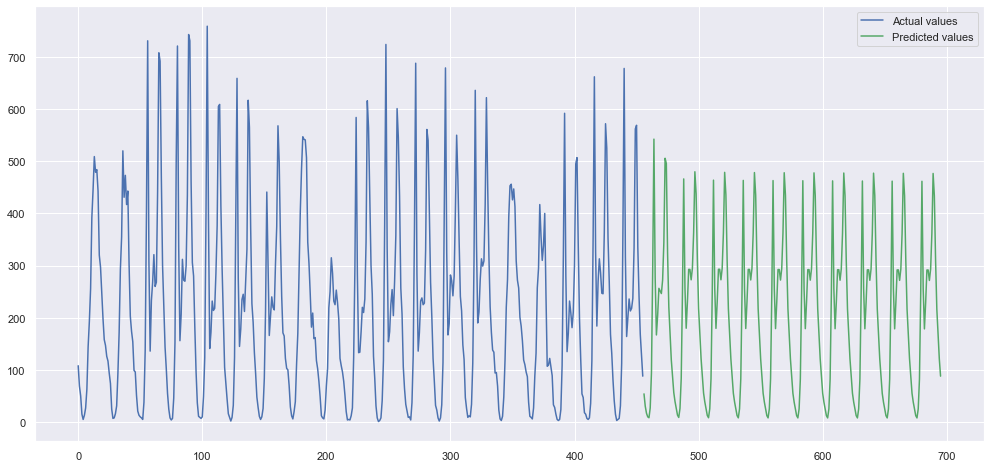

In [22]:
# Plot the predictions
plt.figure(figsize=(17,8))
plt.plot(pd.Series(future_df["count"].values), label='Actual values')
plt.plot(pd.Series(future_df["forecast"].values), 'g', label='Predicted values')
plt.legend(loc='best')
plt.grid(True)